<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam,SGD
from skimage.segmentation import mark_boundaries
from xml.etree import ElementTree

Using TensorFlow backend.


Model 22

In [4]:
saved_model = load_model('/content/drive/My Drive/xai_model/model_22.h5')














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
saved_model.layers[0].input_shape

(None, None, None, 3)

In [0]:
saved_model.summary()

In [0]:
annotation = '/content/drive/My Drive/NEU-DET/ANNOTATIONS/pitted_surface_158.xml'
image_path="/content/drive/My Drive/NEU surface defect database - test split/Test/PS/PS_158.bmp"

[[4.2885816e-08 1.1847902e-08 9.9998367e-01 9.0323711e-06 1.6631745e-09
  7.2796538e-06]]
Pitted Surface


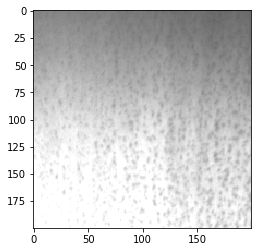

In [8]:
image_path_copy = image_path
img = image.load_img(image_path, target_size=(200,200))
b_img = cv2.imread(image_path)
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
result = saved_model.predict(img)
print(result)

prediction = result.argmax(axis=-1)

if prediction == 0:
  label = "Crazing" 
elif prediction == 1:
  label = "Inclusion"
elif prediction == 2:
  label = "Pitted Surface"
elif prediction == 3:
  label = "Patches"
elif prediction == 4:
  label = "Rolled-in scale"
elif prediction == 5:
  label = "Scratches"
else:
  label = "Exception"

print(label)

In [9]:
def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

boxes = extract_boxes(annotation)

print(boxes)


[[12, 8, 198, 198]]


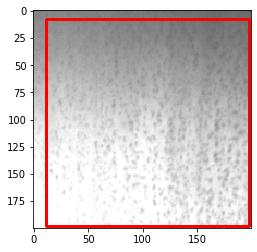

In [10]:
for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  #print(pt1, pt2)
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 2)
  plt.imshow(b_img)

In [11]:
!pip install lime

     |████████████████████████████████| 276kB 6.1MB/s 
  Created wheel for lime: filename=lime-0.1.1.36-cp36-none-any.whl size=284191 sha256=e642dcb4f910c85a461e20b21ab8e5ed3e1546371fc91e535ca119456e3cf9e9
  Stored in directory: /root/.cache/pip/wheels/a9/2f/25/4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [0]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [0]:
explainer = lime_image.LimeImageExplainer()

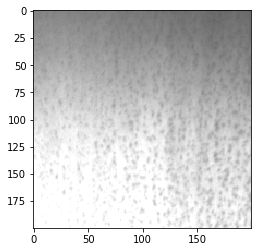

In [14]:
img = image.load_img(image_path_copy, target_size=(200,200))
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

In [15]:
%%time
# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img[0], saved_model.predict, top_labels=5, hide_color=0)

CPU times: user 4.99 s, sys: 1.22 s, total: 6.21 s
Wall time: 5.96 s


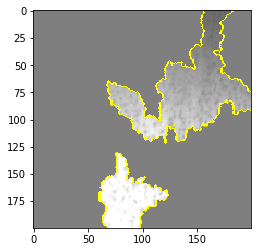

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

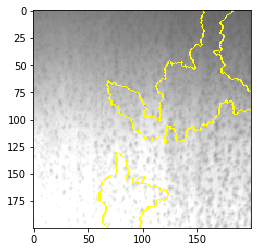

In [17]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
#plt.savefig('/content/drive/My Drive/XAI_results/LIME_Pa_279_2.jpg')

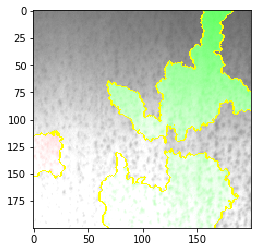

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
#plt.savefig('/content/drive/My Drive/XAI_results/LIME_Pa_279.jpg')

In [0]:
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False, min_weight=0.5)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [20]:
pip install shap

     |████████████████████████████████| 266kB 6.8MB/s 
  Created wheel for shap: filename=shap-0.31.0-cp36-cp36m-linux_x86_64.whl size=374997 sha256=36e5237ace001783348169a5180e59a9d3af930b706908ee24a57b860243c84c
  Stored in directory: /root/.cache/pip/wheels/7b/2d/46/ff8959add2e4e99a18a6e90b82f47508bf52fdf7e7d806f7df
Successfully built shap


In [0]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

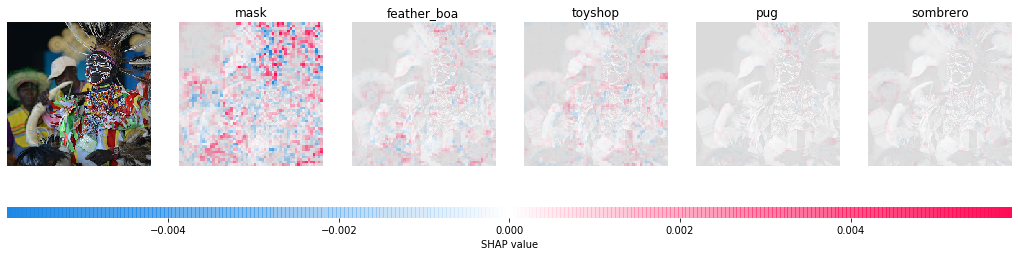

In [25]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[7]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=5)

# get the names for the classes
index_names = np.vectorize(lambda y: class_names[str(y)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [27]:
indexes

array([[643, 552, 865, 254, 808]])

In [26]:
#class_names
index_names

array([['mask', 'feather_boa', 'toyshop', 'pug', 'sombrero']],
      dtype='<U11')

In [0]:
#class_names

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


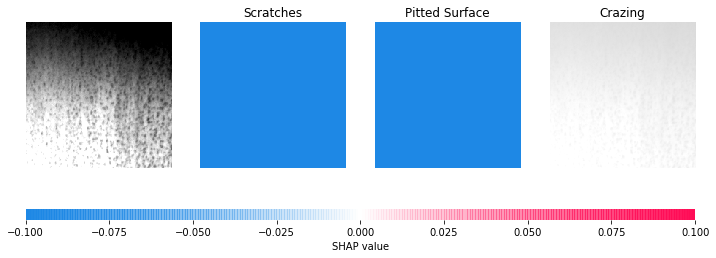

In [42]:
import keras.backend as K
import numpy as np
import shap

def map2layer(x, layer):
  feed_dict = dict(zip([saved_model.layers[0].input], [preprocess_input(x.copy())]))  
  return K.get_session().run(saved_model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((saved_model.layers[5].input, saved_model.layers[-1].output), map2layer(img, 5), local_smoothing=0)

shap_values, indexes = e.shap_values(map2layer(img, 5), ranked_outputs=3)

index_names = np.vectorize(lambda l: labels[l])(indexes)

shap.image_plot(shap_values, img, index_names)


In [32]:
indexes

array([[5, 2, 0]])

In [38]:
labels[5, 1]

KeyError: ignored

In [0]:
if prediction == 0:
  label = "Crazing" 
elif prediction == 1:
  label = "Inclusion"
elif prediction == 2:
  label = "Pitted Surface"
elif prediction == 3:
  label = "Patches"
elif prediction == 4:
  label = "Rolled-in scale"
elif prediction == 5:
  label = "Scratches"
else:
  label = "Exception"